In [1]:
import os
import io

import detectron2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import numpy as np
import cv2
import torch

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [2]:
# Load VG Classes
data_path = 'data/genome/1600-400-20'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())

vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())


MetadataCatalog.get("vg").thing_classes = vg_classes
MetadataCatalog.get("vg").attr_classes = vg_attrs

In [3]:
cfg = get_cfg()
cfg.merge_from_file("../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml")
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
# VG Weight
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"
predictor = DefaultPredictor(cfg)

Config '../configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Modifications for VG in ResNet Backbone (modeling/backbone/resnet.py):
	Using pad 0 in stem max_pool instead of pad 1.

Modifications for VG in RPN (modeling/proposal_generator/rpn.py):
	Use hidden dim 512 instead fo the same dim as Res4 (1024).

Modifications for VG in RoI heads (modeling/roi_heads/roi_heads.py):
	1. Change the stride of conv1 and shortcut in Res5.Block1 from 2 to 1.
	2. Modifying all conv2 with (padding: 1 --> 2) and (dilation: 1 --> 2).
	For more details, please check 'https://github.com/peteanderson80/bottom-up-attention/blob/master/models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'.

Modifications for VG in RoI heads (modeling/roi_heads/fast_rcnn.py))
	Embedding: 1601 --> 256	Linear: 2304 --> 512	Linear: 512 --> 401



In [4]:
# coding=utf-8
# Copyleft 2019 Project LXRT

import sys
import csv
import base64
import time

import numpy as np

csv.field_size_limit(sys.maxsize)
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]


def load_obj_tsv(fname, topk=None):
    """Load object features from tsv file.

    :param fname: The path to the tsv file.
    :param topk: Only load features for top K images (lines) in the tsv file.
        Will load all the features if topk is either -1 or None.
    :return: A list of image object features where each feature is a dict.
        See FILENAMES above for the keys in the feature dict.
    """
    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        for i, item in enumerate(reader):

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])
            
            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes, ), np.int64),
                ('objects_conf', (boxes, ), np.float32),
                ('attrs_id', (boxes, ), np.int64),
                ('attrs_conf', (boxes, ), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                item[key] = item[key].reshape(shape)
                item[key].setflags(write=False)

            data.append(item)
            if topk is not None and len(data) == topk:
                break
    elapsed_time = time.time() - start_time
    print("Loaded %d images in file %s in %d seconds." % (len(data), fname, elapsed_time))
    return data

data = load_obj_tsv('data/caffe_coco_features/train2014_obj36.tsv')


Start to load Faster-RCNN detected objects from data/caffe_coco_features/train2014_obj36.tsv
Loaded 10 images in file data/caffe_coco_features/train2014_obj36.tsv in 0 seconds.


In [13]:
NUM_OBJECTS = 36

from torch import nn

from detectron2.modeling.postprocessing import detector_postprocess
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers, FastRCNNOutputs, fast_rcnn_inference_single_image
from detectron2.structures.boxes import Boxes
from detectron2.structures.instances import Instances

def doit(raw_image, raw_boxes):
        # Process Boxes
    raw_boxes = Boxes(torch.from_numpy(raw_boxes))
    
    with torch.no_grad():
        raw_height, raw_width = raw_image.shape[:2]
#         print("Original image size: ", (raw_height, raw_width))
        
        # Preprocessing
        image = predictor.transform_gen.get_transform(raw_image).apply_image(raw_image)
#         print("Transformed image size: ", image.shape[:2])
        
        # Scale the box
        new_height, new_width = image.shape[:2]
        scale_x = 1. * new_width / raw_width
        scale_y = 1. * new_height / raw_height
        #print(scale_x, scale_y)
        boxes = raw_boxes.clone()
        boxes.scale(scale_x=scale_x, scale_y=scale_y)
        
        # ----
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": raw_height, "width": raw_width}]
        images = predictor.model.preprocess_image(inputs)
        
        # Run Backbone Res1-Res4
        features = predictor.model.backbone(images.tensor)
        print('images.tensor: ', images.tensor)
        print('features: ', features)
        
        
        # Run RoI head for each proposal (RoI Pooling + Res5)
        proposal_boxes = [boxes]
        features = [features[f] for f in predictor.model.roi_heads.in_features]
        print('features: ', features[0].mean(), features[0].min(), features[0].max())
        box_features = predictor.model.roi_heads._shared_roi_transform(
            features, proposal_boxes
        )
        feature_pooled = box_features.mean(dim=[2, 3])  # pooled to 1x1
#         print('Pooled features size:', feature_pooled.shape)
        
        # Predict classes        pred_class_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled) and boxes for each proposal.
        pred_class_logits, pred_attr_logits, pred_proposal_deltas = predictor.model.roi_heads.box_predictor(feature_pooled)
        pred_class_prob = nn.functional.softmax(pred_class_logits, -1)
        pred_scores, pred_classes = pred_class_prob[..., :-1].max(-1)
        
        attr_prob = pred_attr_logits[..., :-1].softmax(-1)
        max_attr_prob, max_attr_label = attr_prob.max(-1)
        
        # Detectron2 Formatting (for visualization only)
        roi_features = feature_pooled
        instances = Instances(
            image_size=(raw_height, raw_width),
            pred_boxes=raw_boxes,
            scores=pred_scores,
            pred_classes=pred_classes,
            attr_scores = max_attr_prob,
            attr_classes = max_attr_label
        )
        
        return instances, roi_features
    


images.tensor:  tensor([[[[71.0199, 71.0199, 72.0199,  ..., 71.0199, 71.0199, 71.0199],
          [71.0199, 71.0199, 72.0199,  ..., 71.0199, 71.0199, 71.0199],
          [71.0199, 71.0199, 72.0199,  ..., 72.0199, 71.0199, 71.0199],
          ...,
          [22.0199, 22.0199, 24.0199,  ..., 18.0199, 18.0199, 18.0199],
          [23.0199, 23.0199, 25.0199,  ..., 20.0199, 19.0199, 19.0199],
          [23.0199, 23.0199, 25.0199,  ..., 20.0199, 19.0199, 19.0199]],

         [[56.0535, 56.0535, 57.0535,  ..., 55.0535, 54.0535, 54.0535],
          [56.0535, 56.0535, 57.0535,  ..., 55.0535, 54.0535, 54.0535],
          [56.0535, 56.0535, 57.0535,  ..., 56.0535, 55.0535, 55.0535],
          ...,
          [16.0535, 16.0535, 17.0535,  ...,  8.0535,  9.0535,  9.0535],
          [17.0535, 17.0535, 18.0535,  ...,  9.0535,  9.0535,  9.0535],
          [17.0535, 17.0535, 18.0535,  ...,  9.0535,  9.0535,  9.0535]],

         [[38.2283, 38.2283, 39.2283,  ..., 41.2283, 42.2283, 42.2283],
          [38.

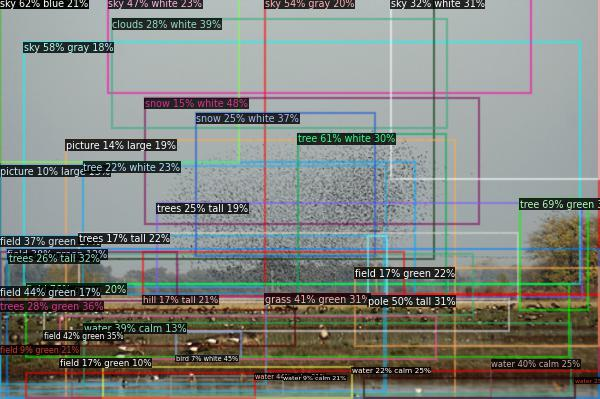

Feature Differences: 0.016179767
Object Ids Differences: 8
Attribute Ids Differences: 9
images.tensor:  tensor([[[[ -75.9801,  -75.9801,  -76.9801,  ...,  -98.9801,  -98.9801,
            -98.9801],
          [ -74.9801,  -75.9801,  -76.9801,  ...,  -98.9801,  -98.9801,
            -98.9801],
          [ -73.9801,  -74.9801,  -75.9801,  ...,  -98.9801,  -98.9801,
            -98.9801],
          ...,
          [ -85.9801,  -90.9801,  -99.9801,  ...,  -61.9801,  -62.9801,
            -62.9801],
          [ -83.9801,  -89.9801,  -98.9801,  ...,  -61.9801,  -61.9801,
            -61.9801],
          [ -82.9801,  -88.9801,  -98.9801,  ...,  -61.9801,  -60.9801,
            -60.9801]],

         [[ -83.9465,  -83.9465,  -82.9465,  ..., -111.9465, -111.9465,
           -111.9465],
          [ -82.9465,  -82.9465,  -82.9465,  ..., -111.9465, -111.9465,
           -111.9465],
          [ -81.9465,  -81.9465,  -81.9465,  ..., -111.9465, -111.9465,
           -111.9465],
          ...,
         

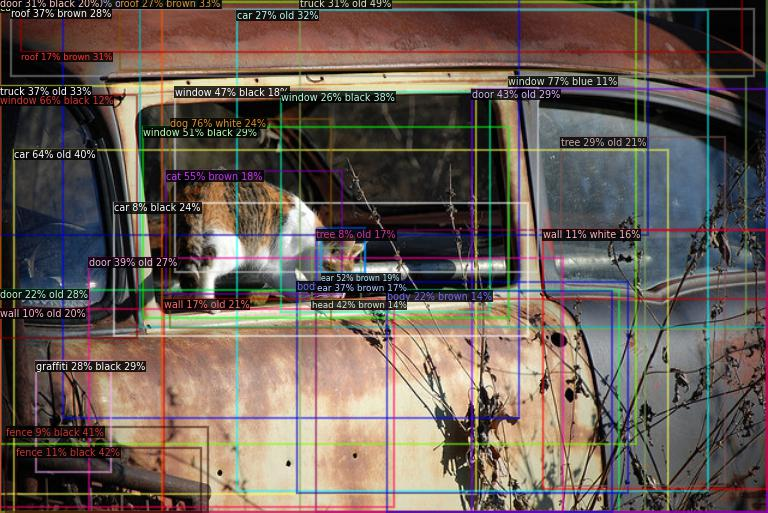

Feature Differences: 0.015755223
Object Ids Differences: 8
Attribute Ids Differences: 3
images.tensor:  tensor([[[[ -99.9801,  -95.9801,  -87.9801,  ..., -101.9801, -102.9801,
           -102.9801],
          [ -99.9801,  -96.9801,  -90.9801,  ..., -101.9801, -102.9801,
           -102.9801],
          [-100.9801,  -99.9801,  -96.9801,  ..., -101.9801, -102.9801,
           -102.9801],
          ...,
          [ -96.9801,  -96.9801,  -95.9801,  ...,  -58.9801,  -51.9801,
            -47.9801],
          [ -90.9801,  -90.9801,  -90.9801,  ...,  -58.9801,  -50.9801,
            -46.9801],
          [ -87.9801,  -87.9801,  -88.9801,  ...,  -58.9801,  -50.9801,
            -46.9801]],

         [[ -57.9465,  -54.9465,  -47.9465,  ..., -107.9465, -108.9465,
           -108.9465],
          [ -66.9465,  -64.9465,  -58.9465,  ..., -107.9465, -108.9465,
           -108.9465],
          [ -86.9465,  -84.9465,  -80.9465,  ..., -106.9465, -107.9465,
           -107.9465],
          ...,
         

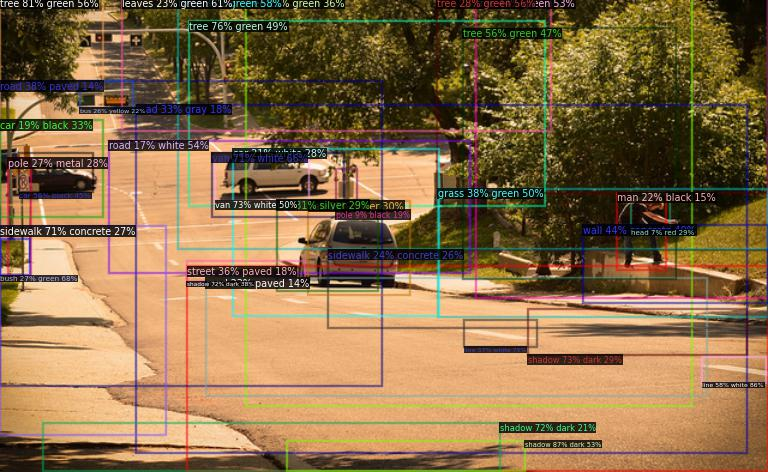

Feature Differences: 0.017496603
Object Ids Differences: 5
Attribute Ids Differences: 8
images.tensor:  tensor([[[[-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          ...,
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801]],

         [[-115.9465, -115.9465, -115.9465,  ..., -115.9465, -115.9465,
           -115.9465],
          [-115.9465, -115.9465, -115.9465,  ..., -115.9465, -115.9465,
           -115.9465],
          [-115.9465, -115.9465, -115.9465,  ..., -115.9465, -115.9465,
           -115.9465],
          ...,
         

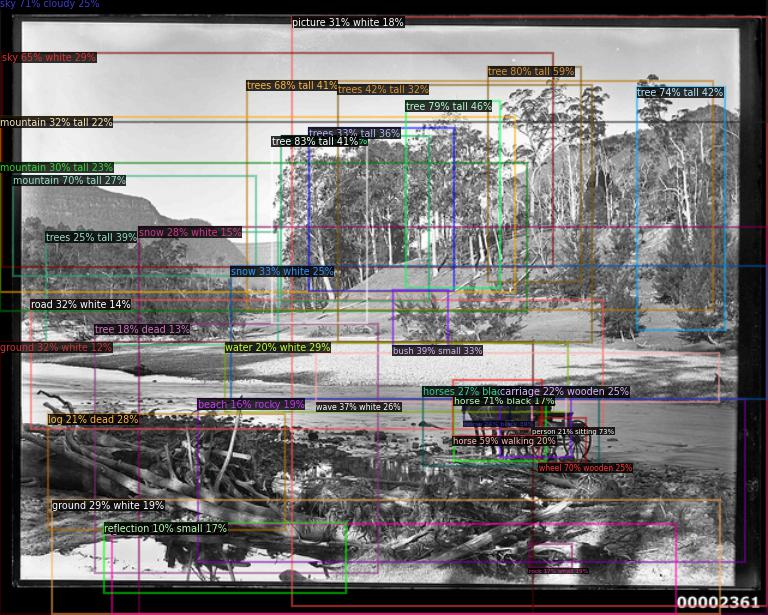

Feature Differences: -0.001033379
Object Ids Differences: 5
Attribute Ids Differences: 7
images.tensor:  tensor([[[[150.0199, 150.0199, 151.0199,  ...,  68.0199,  66.0199,  65.0199],
          [141.0199, 142.0199, 144.0199,  ...,  67.0199,  64.0199,  63.0199],
          [122.0199, 124.0199, 129.0199,  ...,  64.0199,  61.0199,  59.0199],
          ...,
          [ 20.0199,  21.0199,  24.0199,  ...,  26.0199,  23.0199,  22.0199],
          [ 21.0199,  22.0199,  25.0199,  ...,  27.0199,  24.0199,  23.0199],
          [ 21.0199,  22.0199,  25.0199,  ...,  27.0199,  24.0199,  23.0199]],

         [[117.0535, 118.0535, 121.0535,  ...,   1.0535,  -0.9465,  -1.9465],
          [108.0535, 109.0535, 113.0535,  ...,  -0.9465,  -2.9465,  -3.9465],
          [ 89.0535,  91.0535,  97.0535,  ...,  -4.9465,  -6.9465,  -8.9465],
          ...,
          [ 27.0535,  28.0535,  31.0535,  ...,  27.0535,  24.0535,  23.0535],
          [ 28.0535,  29.0535,  32.0535,  ...,  28.0535,  25.0535,  24.0535],
     

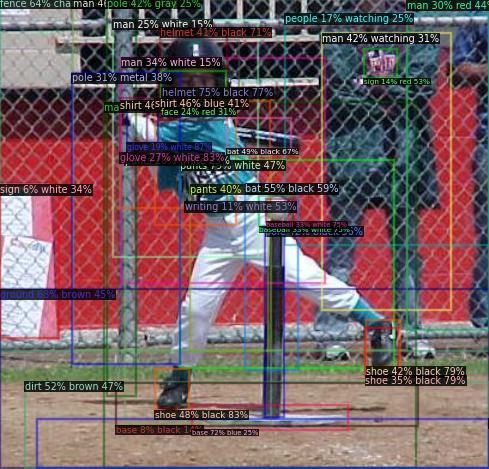

Feature Differences: 0.03690513
Object Ids Differences: 8
Attribute Ids Differences: 5
images.tensor:  tensor([[[[-1.3980e+01, -1.7980e+01, -2.3980e+01,  ..., -1.5980e+01,
           -1.1980e+01, -9.9801e+00],
          [-7.9801e+00, -1.3980e+01, -2.3980e+01,  ..., -1.6980e+01,
           -1.1980e+01, -7.9801e+00],
          [ 1.9897e-02, -8.9801e+00, -2.2980e+01,  ..., -1.7980e+01,
           -1.0980e+01, -5.9801e+00],
          ...,
          [-9.1980e+01, -9.4980e+01, -9.8980e+01,  ..., -8.9980e+01,
           -9.0980e+01, -9.1980e+01],
          [-8.8980e+01, -9.0980e+01, -9.3980e+01,  ..., -8.8980e+01,
           -8.9980e+01, -9.0980e+01],
          [-8.6980e+01, -8.7980e+01, -8.9980e+01,  ..., -8.8980e+01,
           -8.9980e+01, -8.9980e+01]],

         [[-3.6947e+01, -3.9947e+01, -4.4947e+01,  ..., -3.7947e+01,
           -3.3947e+01, -3.1947e+01],
          [-3.1947e+01, -3.6947e+01, -4.4947e+01,  ..., -3.7947e+01,
           -3.1947e+01, -2.8947e+01],
          [-2.3947e+01, 

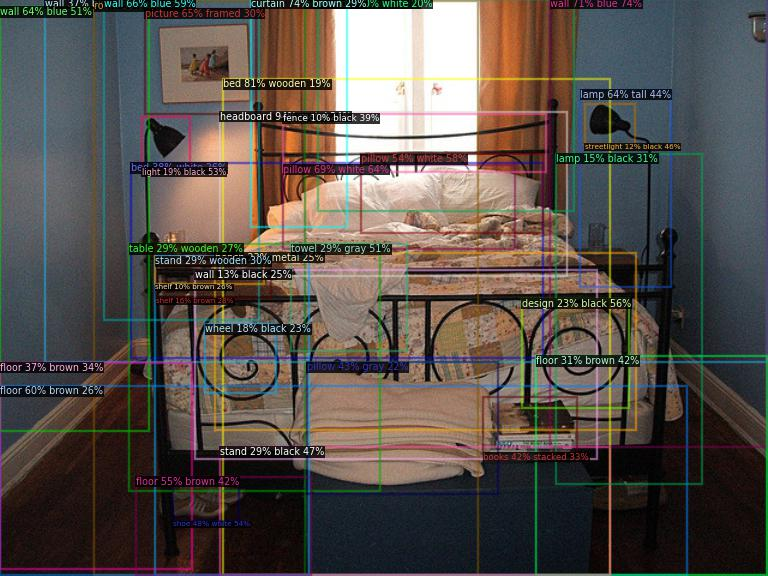

Feature Differences: 0.017681606
Object Ids Differences: 7
Attribute Ids Differences: 3
images.tensor:  tensor([[[[ -87.9801,  -87.9801,  -88.9801,  ...,  -47.9801,  -46.9801,
            -45.9801],
          [ -88.9801,  -88.9801,  -88.9801,  ...,  -46.9801,  -45.9801,
            -44.9801],
          [ -90.9801,  -90.9801,  -89.9801,  ...,  -44.9801,  -43.9801,
            -42.9801],
          ...,
          [ -95.9801,  -96.9801,  -99.9801,  ..., -101.9801, -100.9801,
            -99.9801],
          [ -92.9801,  -94.9801,  -98.9801,  ..., -101.9801, -100.9801,
            -99.9801],
          [ -90.9801,  -92.9801,  -97.9801,  ..., -101.9801, -100.9801,
            -99.9801]],

         [[ -80.9465,  -79.9465,  -78.9465,  ...,   -7.9465,   -5.9465,
             -4.9465],
          [ -80.9465,  -80.9465,  -79.9465,  ...,   -6.9465,   -4.9465,
             -3.9465],
          [ -81.9465,  -81.9465,  -80.9465,  ...,   -4.9465,   -2.9465,
             -1.9465],
          ...,
         

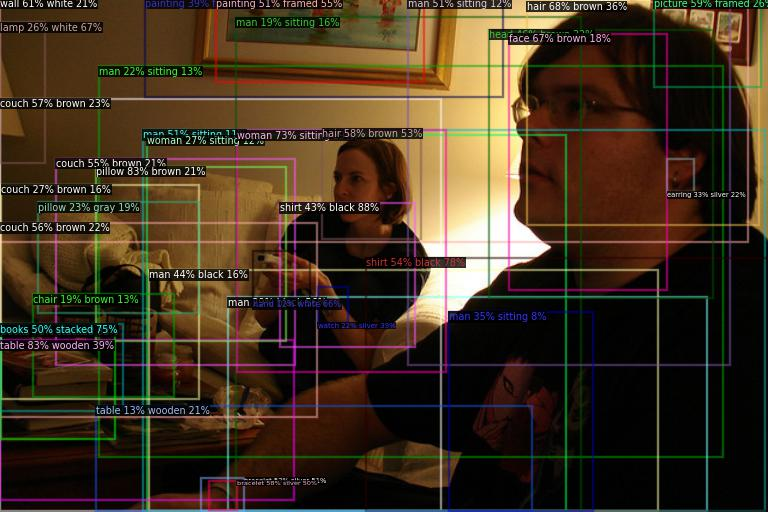

Feature Differences: 0.023268946
Object Ids Differences: 5
Attribute Ids Differences: 3
images.tensor:  tensor([[[[ 7.5020e+01,  7.5020e+01,  7.4020e+01,  ...,  9.7020e+01,
            9.6020e+01,  9.6020e+01],
          [ 7.5020e+01,  7.5020e+01,  7.5020e+01,  ...,  9.7020e+01,
            9.6020e+01,  9.6020e+01],
          [ 7.6020e+01,  7.6020e+01,  7.6020e+01,  ...,  9.8020e+01,
            9.7020e+01,  9.7020e+01],
          ...,
          [-9.8010e-01,  1.9897e-02,  1.9897e-02,  ...,  1.3020e+01,
            1.2020e+01,  1.1020e+01],
          [ 3.0199e+00,  3.0199e+00,  1.0199e+00,  ...,  1.2020e+01,
            1.0020e+01,  8.0199e+00],
          [ 5.0199e+00,  4.0199e+00,  1.0199e+00,  ...,  1.2020e+01,
            9.0199e+00,  7.0199e+00]],

         [[ 5.0535e+00,  4.0535e+00,  2.0535e+00,  ...,  2.7053e+01,
            2.6053e+01,  2.6053e+01],
          [ 5.0535e+00,  4.0535e+00,  2.0535e+00,  ...,  2.7053e+01,
            2.6053e+01,  2.6053e+01],
          [ 4.0535e+00,

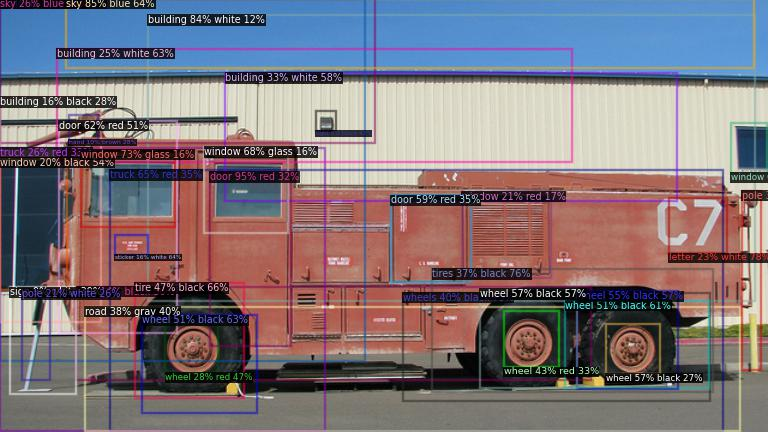

Feature Differences: 0.018676892
Object Ids Differences: 5
Attribute Ids Differences: 4
images.tensor:  tensor([[[[ 72.0199,  72.0199,  71.0199,  ...,  90.0199,  90.0199,  90.0199],
          [ 72.0199,  72.0199,  71.0199,  ...,  89.0199,  89.0199,  89.0199],
          [ 73.0199,  73.0199,  72.0199,  ...,  88.0199,  88.0199,  88.0199],
          ...,
          [ 14.0199,  11.0199,   4.0199,  ...,  -0.9801,   1.0199,   2.0199],
          [ 19.0199,  14.0199,   5.0199,  ...,  -1.9801,  -1.9801,  -2.9801],
          [ 22.0199,  16.0199,   5.0199,  ...,  -2.9801,  -3.9801,  -4.9801]],

         [[-29.9465, -29.9465, -30.9465,  ...,  10.0535,  10.0535,  10.0535],
          [-28.9465, -28.9465, -29.9465,  ...,  10.0535,  10.0535,  10.0535],
          [-27.9465, -27.9465, -28.9465,  ...,  10.0535,   9.0535,   9.0535],
          ...,
          [ -8.9465, -13.9465, -22.9465,  ..., -39.9465, -38.9465, -37.9465],
          [-10.9465, -14.9465, -23.9465,  ..., -38.9465, -37.9465, -36.9465],
      

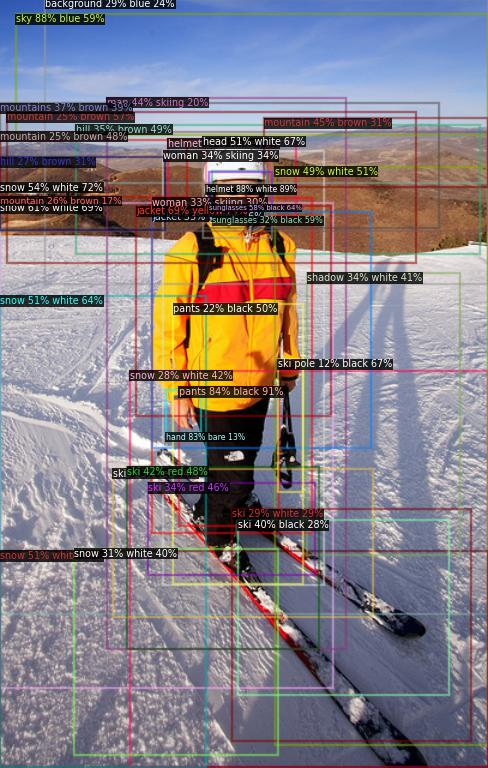

Feature Differences: 0.015090202
Object Ids Differences: 7
Attribute Ids Differences: 1
images.tensor:  tensor([[[[ -5.9801,  -5.9801,  -4.9801,  ..., -63.9801, -62.9801, -61.9801],
          [  2.0199,   2.0199,   2.0199,  ..., -64.9801, -63.9801, -62.9801],
          [ 16.0199,  15.0199,  14.0199,  ..., -66.9801, -65.9801, -64.9801],
          ...,
          [  8.0199,   8.0199,   9.0199,  ...,   6.0199,   4.0199,   3.0199],
          [  9.0199,   9.0199,   9.0199,  ...,   5.0199,   3.0199,   2.0199],
          [  9.0199,   9.0199,   9.0199,  ...,   5.0199,   3.0199,   2.0199]],

         [[-58.9465, -59.9465, -60.9465,  ..., -76.9465, -75.9465, -74.9465],
          [-54.9465, -55.9465, -56.9465,  ..., -77.9465, -76.9465, -75.9465],
          [-48.9465, -49.9465, -50.9465,  ..., -79.9465, -78.9465, -77.9465],
          ...,
          [-35.9465, -35.9465, -34.9465,  ..., -16.9465, -17.9465, -18.9465],
          [-34.9465, -34.9465, -34.9465,  ..., -17.9465, -18.9465, -19.9465],
      

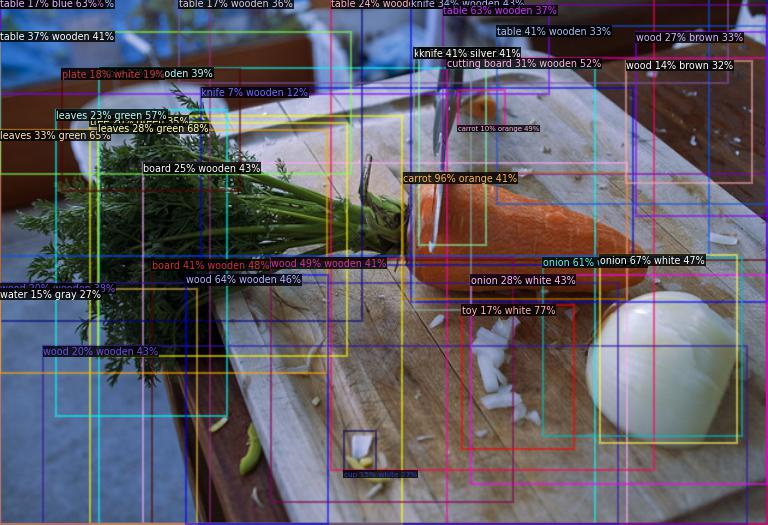

Feature Differences: 0.0015243283
Object Ids Differences: 11
Attribute Ids Differences: 2


In [8]:
# Show the boxes, labels, and features
#FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              #"attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]
for datum in data:
    im = cv2.imread('data/images/' + datum['img_id'] + '.jpg')
    given_boxes = datum['boxes']
    instances, features = doit(im, given_boxes)
    pred = instances.to('cpu')
    v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
    v = v.draw_instance_predictions(pred)
    showarray(v.get_image()[:, :, ::-1])
    print("Feature Differences:", (features.cpu().numpy() - datum['features']).mean())
    print("Object Ids Differences:", (instances.pred_classes.cpu().numpy() != datum['objects_id']).sum())
    print("Attribute Ids Differences:", (instances.attr_classes.cpu().numpy() != datum['attrs_id']).sum())
    


images.tensor:  tensor([[[[-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          ...,
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801],
          [-102.9801, -102.9801, -102.9801,  ..., -102.9801, -102.9801,
           -102.9801]],

         [[-115.9465, -115.9465, -115.9465,  ..., -115.9465, -115.9465,
           -115.9465],
          [-115.9465, -115.9465, -115.9465,  ..., -115.9465, -115.9465,
           -115.9465],
          [-115.9465, -115.9465, -115.9465,  ..., -115.9465, -115.9465,
           -115.9465],
          ...,
          [-115.9465, -115.9465, -115.9465,  ..., -115.9465, -115.9465,
           -115.9465],
  

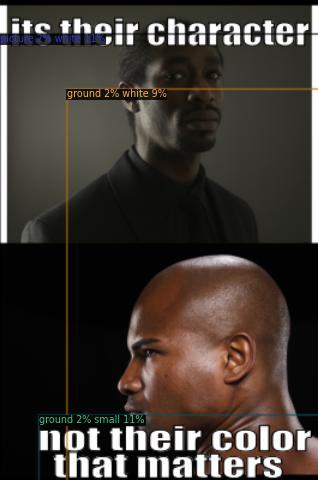

ValueError: operands could not be broadcast together with shapes (7,2048) (36,2048) 

In [16]:
im = cv2.imread('/home/ron/Downloads/hateful_meme_data/img/42953.png')
given_boxes = datum['boxes']
# given_boxes = np.array(
#     [[ 294.3217,  734.9891,  559.1793, 1110.9277],
#     [ 339.7852,  113.7795,  566.7401,  385.4785],
#     [  55.5721,   75.3408,  674.5536,  623.3557],
#     [ 239.3932,  650.3275,  757.7485, 1177.7111],
#     [  32.8885,  346.1343,  673.9932,  626.7932],
#     [   0.0000,   29.4954,  785.8928,  684.8771],
#     [ 289.9026,  895.4448,  356.8830,  999.8890]])
instances, features = doit(im, given_boxes)
pred = instances.to('cpu')
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])
print("Feature Differences:", (features.cpu().numpy() - datum['features']).mean())
print("Object Ids Differences:", (instances.pred_classes.cpu().numpy() != datum['objects_id']).sum())
print("Attribute Ids Differences:", (instances.attr_classes.cpu().numpy() != datum['attrs_id']).sum())

In [15]:
given_boxes

array([[336.21957  , 145.25447  , 522.12195  , 249.91661  ],
       [500.07913  , 213.63414  , 614.0871   , 369.89276  ],
       [154.9278   , 230.02655  , 273.7167   , 437.27     ],
       [369.30576  ,   5.8805957, 639.48     , 145.8948   ],
       [372.46585  ,  49.9561   , 639.48     , 437.27     ],
       [  0.       ,   0.       , 590.46484  , 214.2696   ],
       [126.43387  , 217.8015   , 639.48     , 437.27     ],
       [342.09766  ,   0.       , 639.48     , 252.39879  ],
       [226.05919  , 216.04898  , 427.52682  , 419.07056  ],
       [348.8802   ,  41.455368 , 404.64267  , 205.46924  ],
       [ 81.59838  , 104.05167  , 288.79382  , 297.3883   ],
       [  0.       ,   0.       , 301.53024  , 268.3052   ],
       [ 82.820625 ,  58.160736 , 495.62115  , 437.27     ],
       [  0.       ,  27.720245 , 292.48288  , 145.76498  ],
       [ 74.63578  ,  98.01687  , 335.00067  , 437.27     ],
       [  0.       , 109.753006 , 272.2849   , 312.03143  ],
       [  0.       ,   0